In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/My Drive/UMass/CS685")

In [ ]:
!pip install git+https://github.com/kteavery/transformers.git


  Cloning https://github.com/kteavery/transformers.git to /tmp/pip-req-build-3wty2bd4
  Running command git clone -q https://github.com/kteavery/transformers.git /tmp/pip-req-build-3wty2bd4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
# !pip install transformers
!pip install datasets
!pip install pytorch_pretrained_bert

In [ ]:
from datasets import load_dataset
med_dialog = load_dataset("medical_dialog", "en", data_dir="./Medical-Dialogue-Dataset-English")
covid_dialog = load_dataset("covid_qa_ucsd", "en", data_dir="./" )

Using custom data configuration en-7ad5e2a1147398cb
Reusing dataset medical_dialog (/root/.cache/huggingface/datasets/medical_dialog/en-7ad5e2a1147398cb/1.0.0/6b4b5348ad77903e71465d9910a30b9ec05dbeed9cb6b45349556a287ce42bab)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration en-data_dir=.%2F
Reusing dataset covid_qa_ucsd (/root/.cache/huggingface/datasets/covid_qa_ucsd/en-data_dir=.%2F/1.0.0/2a15b6e8fdc7cee91951d8f20ac2b26ede79fbef988919fbde22dbb97bf4df81)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
import pandas as pd

In [ ]:
cd_df = covid_dialog['train'].to_pandas()

In [ ]:
md_df = med_dialog['train'].to_pandas()

In [ ]:
print(md_df["dialogue_turns"])

0         {'speaker': [0, 1], 'utterance': ['Will mastur...
1         {'speaker': [0, 1], 'utterance': ['Could lack ...
2         {'speaker': [0, 1], 'utterance': ['What causes...
3         {'speaker': [0, 1], 'utterance': ['What cause ...
4         {'speaker': [0, 1], 'utterance': ['How to get ...
                                ...                        
229669    {'speaker': [0, 1], 'utterance': ['Q. Brother-...
229670    {'speaker': [0, 1], 'utterance': ['Q. Having o...
229671    {'speaker': [0, 1], 'utterance': ['Q. How long...
229672    {'speaker': [0, 1], 'utterance': ['Q. Tried wi...
229673    {'speaker': [0, 1], 'utterance': ['Q. How to r...
Name: dialogue_turns, Length: 229674, dtype: object


In [ ]:
print(cd_df["dialogue_turns"])

0      {'speaker': [0, 1, 0, 1], 'utterance': ['I hav...
1      {'speaker': [0, 1, 0, 1, 0, 1, 0, 1], 'utteran...
2      {'speaker': [0, 1], 'utterance': ['Can Coronav...
3      {'speaker': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...
4      {'speaker': [0, 1], 'utterance': ['Does COVID-...
                             ...                        
567    {'speaker': [0, 1], 'utterance': ['If I get co...
568    {'speaker': [0, 1], 'utterance': ['I was on a ...
569    {'speaker': [0, 1], 'utterance': ['My son has ...
570    {'speaker': [0, 1], 'utterance': ['Can coronav...
571    {'speaker': [0, 1], 'utterance': ['Good day,  ...
Name: dialogue_turns, Length: 572, dtype: object


In [ ]:
text = []
augtext = []
for dial in cd_df["dialogue_turns"]:
  u = dial["utterance"]
  for i in range(0,len(u),2):
    pq = u[i:i+2]
    text.append(['<|endoftext|>'.join(pq)])
    augtext.append(['<|endoftext|>'.join(pq)])
qa_df = pd.DataFrame(text, columns=["text"])

In [ ]:
for dial in md_df["dialogue_turns"]:
  u = dial["utterance"]
  for i in range(0,len(u), 2):
    pq = u[i:i+2]
    if i % 100 == 0:
      augtext.append(['<|endoftext|>'.join(pq)])
aug_qa_df = pd.DataFrame(text, columns=["text"])

In [ ]:
print(len(qa_df))

583


In [ ]:
qa_df["text"]

0      I have cough with no travel history. Is this a...
1      Thank you doctor,I have phlegm but not a lot. ...
2      I have a little fever with no history of forei...
3      Thank you doctor,After doing all these I can u...
4      Thank you doctor,As per your guidelines, I hav...
                             ...                        
578    If I get coronavirus, are there ways to avoid ...
579    I was on a plane on March 8th have been home e...
580    My son has a fever, I am concerned due to the ...
581    Can coronavirus symptoms be mild for some peop...
582    Good day,  I am 29 weeks pregnant and my profe...
Name: text, Length: 583, dtype: object

In [ ]:
# Note: We may want to do prefix masked lm and not just generate the whole sequence
# We should probably truncate sequences on LHS
# It might also be good to split sentences with special doctor patient tokens.

In [ ]:
print(qa_df)

                                                  text
0    I have cough with no travel history. Is this a...
1    Thank you doctor,I have phlegm but not a lot. ...
2    I have a little fever with no history of forei...
3    Thank you doctor,After doing all these I can u...
4    Thank you doctor,As per your guidelines, I hav...
..                                                 ...
578  If I get coronavirus, are there ways to avoid ...
579  I was on a plane on March 8th have been home e...
580  My son has a fever, I am concerned due to the ...
581  Can coronavirus symptoms be mild for some peop...
582  Good day,  I am 29 weeks pregnant and my profe...

[583 rows x 1 columns]


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AdamW, GPT2LMHeadModel, GPT2DoubleHeadsModel, GPT2TokenizerFast, GPT2Config, BertTokenizer

from transformers.modeling_outputs import CausalLMOutputWithCrossAttentions
from transformers.models.gpt2.modeling_gpt2 import GPT2DoubleHeadsModelOutput
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from pytorch_pretrained_bert.modeling_gpt2 import GPT2PreTrainedModel, GPT2MultipleChoiceHead, GPT2Model, GPT2LMHead, Attention, Block, \
    LayerNorm, MLP

In [ ]:
import os
import time
import datetime
# from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
text = aug_qa_df.text.copy()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


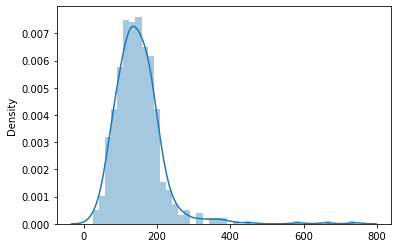

In [ ]:
doc_lengths = []

for bio in text:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)
             

In [ ]:
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small")
# tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-large-cased-v1.1')

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

In [ ]:
# if not tokenizer.eos_token :
#   tokenizer.eos_token = '<|endoftext|>' 

In [ ]:
batch_size = 2
tokenizer.pad_token = tokenizer.eos_token
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer(txt + tokenizer.eos_token, truncation=True, max_length=max_length, padding="max_length")
      
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [ ]:
dataset = GPT2Dataset(text, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  524 training samples
   59 validation samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
)

In [ ]:
# I'm not really doing anything with the config buheret
# configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
# model = GPT2LMHeadModel.from_pretrained("microsoft/DialoGPT-small")
# model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
# if torch.cuda.is_available() and useCuda:
device = torch.device("cuda")
model.cuda()
# else:
#   device = torch.device("cpu")

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100


In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))
    

In [ ]:
print(model.device)

cuda:0


In [ ]:
total_t0 = time.time()

training_stats = []

# model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
  
        model.zero_grad()        

        outputs = model(b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    # bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    262. Loss: 0.6914129853248596.   Elapsed: 0:01:41.
0: In brief:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    262. Loss: 0.7282368540763855.   Elapsed: 0:03:21.
0: 

  Average training loss: 1.09
  Training epoch took: 0:04:22

Running Validation...
  Validation Loss: 0.65
  Validation took: 0:00:09

======== Epoch 2 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    262. Loss: 0.6618049740791321.   Elapsed: 0:01:40.
0: 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    262. Loss: 0.8467816114425659.   Elapsed: 0:03:20.
0: ?

  Average training loss: 0.64
  Training epoch took: 0:04:22

Running Validation...
  Validation Loss: 0.62
  Validation took: 0:00:09

======== Epoch 3 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    262. Loss: 0.6292179226875305.   Elapsed: 0:01:40.
0: ?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    262. Loss: 0.5060659646987915.   Elapsed: 0:03:19.
0: ,,  Would you like to video or text chat with me?

  Average training loss: 0.53
  Training epoch took: 0:04:21

Running Validation...
  Validation Loss: 0.61
  Validation took: 0:00:09

======== Epoch 4 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    262. Loss: 0.46504372358322144.   Elapsed: 0:01:40.
0: 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    262. Loss: 0.17457349598407745.   Elapsed: 0:03:21.
0: ,

  Average training loss: 0.43
  Training epoch took: 0:04:22

Running Validation...
  Validation Loss: 0.63
  Validation took: 0:00:09

======== Epoch 5 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    262. Loss: 0.32694652676582336.   Elapsed: 0:01:40.
0: 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    262. Loss: 0.33785808086395264.   Elapsed: 0:03:20.
0: ?

  Average training loss: 0.35
  Training epoch took: 0:04:22

Running Validation...
  Validation Loss: 0.66
  Validation took: 0:00:09

Training complete!
Total training took 0:22:36 (h:mm:ss)


In [ ]:
import pandas as pd
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats


,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.09,0.65,0:04:22,0:00:09
2,0.64,0.62,0:04:22,0:00:09
3,0.53,0.61,0:04:21,0:00:09
4,0.43,0.63,0:04:22,0:00:09
5,0.35,0.66,0:04:22,0:00:09


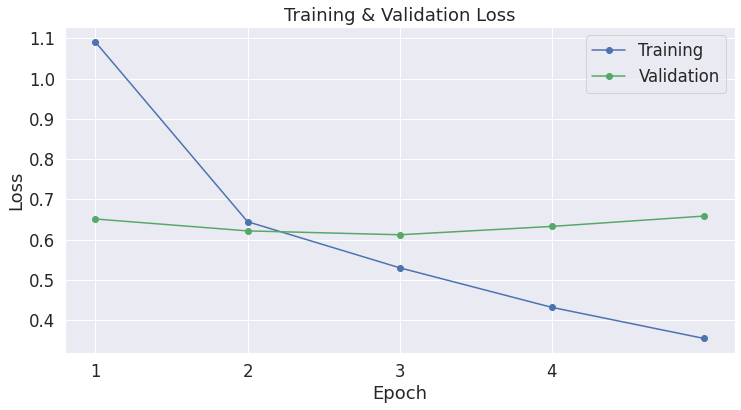

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50257, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [ ]:
print(model.device)

print(bot_input_ids1.device)

print(chat_history_ids1.device)

# Can't be different

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './models/baseline-augmented/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./models/baseline-augmented/


('./models/baseline-augmented/tokenizer_config.json',
 './models/baseline-augmented/special_tokens_map.json',
 './models/baseline-augmented/vocab.json',
 './models/baseline-augmented/merges.txt',
 './models/baseline-augmented/added_tokens.json',
 './models/baseline-augmented/tokenizer.json')

In [ ]:
ls

baseline-1.ipynb                    helper.py
baseline-augmented.ipynb            integration-script.ipynb
biobert.ipynb                       Medical-Dialogue-Dataset-English/
COVID-Dialogue-Dataset-English.txt  models/
data.py                             plots.py
decoder_only.ipynb                  __pycache__/
gpt_covid.ipynb                     README.md


In [ ]:
!echo "models/" >> .gitignore

In [ ]:
!cat .gitignore

Medical-Dialogue-Dataset-English/
Medical-Dialogue-Dataset-English/
.DS_Store
transformers
transformers/
models/


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("models/baseline-augmented")
model = AutoModelForCausalLM.from_pretrained("models/baseline-augmented")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [ ]:
model.eval()
step = 0
while True:
    context = input(">> User:")
    if context == "I am done talking":
      print("DoctorBot: Ok bye bye")
      break
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids1 = tokenizer(context + tokenizer.eos_token, return_tensors='pt').input_ids
    new_user_input_ids1 = new_user_input_ids1.to(device)
    # append the new user input tokens to the chat history
    bot_input_ids1 = torch.cat([chat_history_ids1, new_user_input_ids1], dim=-1) if step > 0 else new_user_input_ids1
    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids1 = model.generate(bot_input_ids1, max_length=1000, return_dict=True)
    print(type(chat_history_ids1))
    step += 1
    # pretty print last ouput tokens from bot
    print("DoctorBot: {}".format(tokenizer.decode(chat_history_ids1[:, bot_input_ids1.shape[-1]:][0], skip_special_tokens=True)))